# Pedalboard: Audio Effects in Python 🎛 🔊

`pedalboard` is a Python package that lets you apply studio-quality audio effects (including VSTs and Audio Units) to audio data in Python, with a focus on ease-of-use and very high performance. Here's a quick run through.

In [1]:
# Some imports we'll need in a second, ignore this cell.
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import subprocess
from IPython.display import Audio
import subprocess
import base64

%matplotlib inline

Let's start by loading some audio - here, one of the example audio files from [the popular `librosa` package](https://librosa.org/):

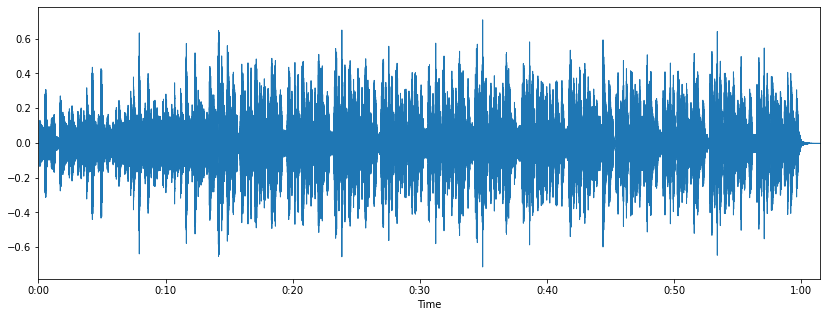

In [2]:
y, sr = librosa.load(librosa.example('vibeace', hq=True), sr=44100)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

Let's play back the first 10 seconds of this audio, so we can hear what it sounds like:

In [3]:
# You can ignore this cell - this allows us to play back lots of audio in a Jupyter notebook on GitHub.
def play_audio(y: np.ndarray, sample_rate: float) -> Audio:
    """
    Small helper to play audio in a Jupyter notebook without
    inflating the file size of the notebook, by encoding to OGG first.
    """
    process = subprocess.Popen([
        'ffmpeg',
        '-f', 'f32le',
        '-ar', str(sample_rate),
        '-i', '-',
        '-f', 'ogg',
        '-'
    ], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    stdout, stderr = process.communicate(y.astype(np.float32).tobytes())
    return Audio(url="data:audio/ogg;base64," + base64.b64encode(stdout).decode("utf-8"), rate=sample_rate)

In [4]:
play_audio(y[:20 * sr], sample_rate=sr)

## Quick start: adding reverb

Now, let's import `pedalboard` and use it to apply some [reverb](https://en.wikipedia.org/wiki/Reverberation) to make our recording sound like it's being played in a large room:

In [5]:
import pedalboard
reverb = pedalboard.Reverb()
reverb

<pedalboard.Reverb room_size=0.5 damping=0.5 wet_level=0.33 dry_level=0.4 width=1 freeze_mode=0 at 0x7fe4526a39e0>

Plugins in `pedalboard` have their parameters exposed as you'd expect in Python - as attributes, which support autocomplete in Jupyter or IPython:

In [6]:
reverb.room_size

0.5

In [7]:
reverb.wet_level = 1.0

Now let's apply this plugin to the audio we were using above by calling it:

In [8]:
# Apply a single plugin to audio by calling that plugin like a function:
effected = reverb(y, sample_rate=sr)

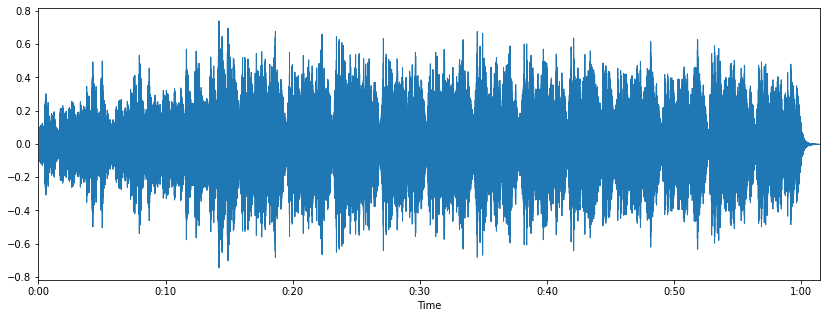

In [9]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(effected, sr=sr)

Let's listen to the result hear what it sounds like:

In [10]:
play_audio(effected[:20 * sr], sample_rate=sr)

Sounds like we've added some reverb!

## Chaining Effects

`pedalboard` gets its name from [guitar pedalboards](https://en.wikipedia.org/wiki/Guitar_pedalboard), which are used to chain effects together. Let's try doing the same thing in Python, with a couple lines of code. First, let's create a `Pedalboard` object that contains multiple plugins that run in sequence:

In [11]:
from pedalboard import Compressor, Gain, Phaser, Reverb

# Make a new Pedalboard object that contains plugins, each with their own (optional) settings
board = pedalboard.Pedalboard([
    Compressor(ratio=10, threshold_db=-20),
    Gain(gain_db=20),
    Phaser(),
    Reverb()
], sample_rate=sr)

board

<Pedalboard plugins=[<pedalboard.Compressor threshold_db=-20 ratio=10 attack_ms=1 release_ms=100 at 0x7fe3e2a30580>, <pedalboard.Gain gain_db=20 at 0x7fe3e2a2f8e0>, <pedalboard.Phaser rate_hz=1 depth=0.5 centre_frequency_hz=1300 feedback=0 mix=0.5 at 0x7fe4846d2800>, <pedalboard.Reverb room_size=0.5 damping=0.5 wet_level=0.33 dry_level=0.4 width=1 freeze_mode=0 at 0x7fe3e2a30e20>] sample_rate=44100>

Now, let's try running audio through this effect chain and see what it looks and sounds like:

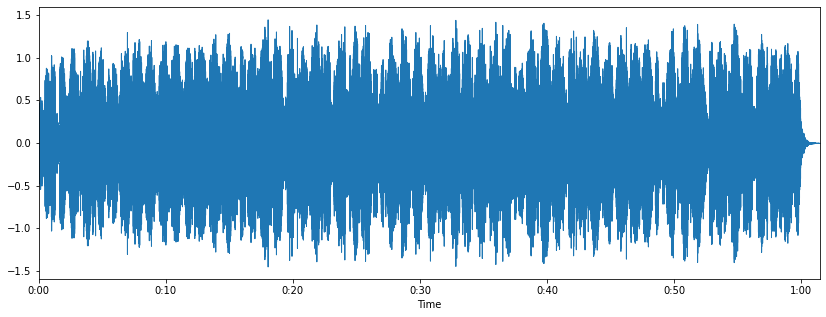

In [12]:
effected = board.process(y)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(effected, sr=sr)

In [13]:
play_audio(effected[:20 * sr], sample_rate=sr)

Neat! We've got a `Compressor` on the audio, which makes the overall volume more consistent. The `Gain` plugin boosts the level by a fixed amount. The `Phaser` produces that "whooshing" sound you hear, and the `Reverb` plugin - like before - makes it sound like we're playing this audio in a large room.

> 💡 **Implementation Details**
>
> Under the hood, `pedalboard` runs our plugins in series, but not how you might expect. Rather than processing the entire audio file through each plugin sequentially, `pedalboard` operates in chunks, much like most professional audio software does. This results in huge speed and memory savings, as only one copy of the audio input is created, and each plugin "visits" sections of the output buffer. The audio processing happens in highly optimized C++ code, and Python's [Global Interpreter Lock](https://wiki.python.org/moin/GlobalInterpreterLock) is released while this code is running, meaning your code can properly use multiple CPU cores to get much higher speed.

Let's try this again, but instead, let's set some of the parameters to more extreme values to see if we can get some really extreme effects:

In [14]:
from pedalboard import Gain, Limiter, LadderFilter, Phaser, Reverb

# Make a new Pedalboard object that contains plugins, each with their own (optional) settings
board = pedalboard.Pedalboard([
    Phaser(rate_hz=1.0, depth=1.0, feedback=0.25, mix=1.0),
    LadderFilter(mode=LadderFilter.HPF12, cutoff_hz=329.63, resonance=0.75),
    Gain(-5),
    Reverb(room_size=0.75, wet_level=0.5),
    Limiter(),
], sample_rate=sr)

for plugin in board:
    print(plugin)

<pedalboard.Phaser rate_hz=1 depth=1 centre_frequency_hz=1300 feedback=0.25 mix=1 at 0x7fe482a0e800>
<pedalboard.LadderFilter mode=pedalboard.LadderFilter.HPF12pedalboard.LadderFilter.BPF12pedalboard.LadderFilter.LPF24pedalboard.LadderFilter.HPF24pedalboard.LadderFilter.BPF24unknown cutoff_hz=329.63 resonance=0.75 drive=1 at 0x7fe4824c0530>
<pedalboard.Gain gain_db=-5 at 0x7fe4824d29a0>
<pedalboard.Reverb room_size=0.75 damping=0.5 wet_level=0.5 dry_level=0.4 width=1 freeze_mode=0 at 0x7fe4824e2ec0>
<pedalboard.Limiter threshold_db=-10 release_ms=100 at 0x7fe4824df3c0>


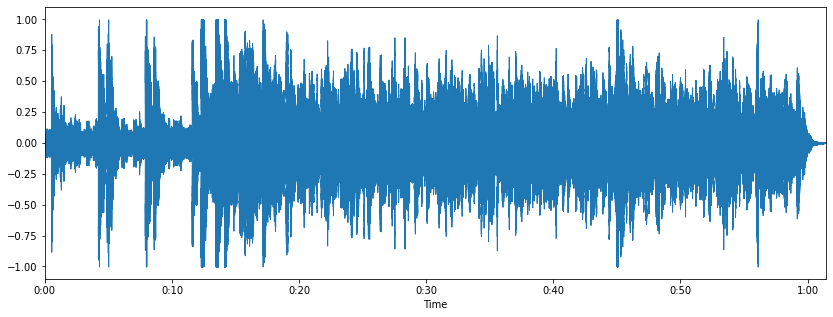

In [15]:
effected = board.process(y)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(effected, sr=sr)

That looks pretty extreme! Let's give it a listen:

In [16]:
play_audio(effected[:20 * sr], sample_rate=sr)

With our new filters, we've got some random-sounding pitch shifting (thanks to the `Phaser`), very little bass (thanks to the `LadderFilter`), and the room sound from the rest of our plugins.

## Third-Party VSTs and Audio Units

The plugins included with `pedalboard` can do a fair bit, but in the world of audio production, most people like to use third-party plugins - usually called VSTs or Audio Units (AUs). `pedalboard` supports both of these formats, depending on which platform you're on.

> 🎵**Note!**
>
> VST plugins are supported on macOS, Linux, and Windows, while Audio Units are only supported on macOS.
> Furthermore, **not all VST plugins are compatible with all operating systems** - in fact, VSTs must explicitly support the operating system you're running `pedalboard` on to work correctly. (That means that if you're running on, say, Linux, you'll only be able to load VST plugins that are explicitly Linux-compatible, which isn't very many.)

Let's give this a try. I'll use `pedalboard.VST3Plugin.installed_plugins` to see what's already installed on my machine:

In [17]:
from pedalboard import load_plugin, VST3Plugin, AudioUnitPlugin
VST3Plugin.installed_plugins

['/Library/Audio/Plug-Ins/VST3/Cut Through Recordings Convergence.vst3',
 '/Library/Audio/Plug-Ins/VST3/Frequalizer.vst3',
 '/Library/Audio/Plug-Ins/VST3/OrilRiver.vst3',
 '/Library/Audio/Plug-Ins/VST3/TAL-Reverb-4.vst3',
 '/Library/Audio/Plug-Ins/VST3/TAL-Reverb-2.vst3',
 '/Library/Audio/Plug-Ins/VST3/RoughRider3.vst3']

Looks like I've already got a couple of VST plugins installed on my machine. (This list of plugins also happens to be a sampling of free, open-source, and/or Linux-compatible VSTs.) Let's load one up and see how it works:

In [18]:
roughrider = load_plugin('/Library/Audio/Plug-Ins/VST3/RoughRider3.vst3')
roughrider

<pedalboard.VST3Plugin "RoughRider3" (2 channels) at 0x7fe4824e8470>

Just like `pedalboard`'s built-in plugins, this VST plugin's parameters are available as properties on the Python object itself. We can use autocomplete in Jupyter (<kbd>TAB</kbd>), [the `dir()` function](https://docs.python.org/3/library/functions.html#dir), or look at `.parameters` to see what parameters the plugin has:

In [19]:
roughrider.parameters.keys()

dict_keys(['sc_hpf_hz', 'input_lvl_db', 'sensitivity_db', 'ratio', 'attack_ms', 'release_ms', 'makeup_db', 'mix', 'output_lvl_db', 'sc_active', 'full_bandwidth', 'bypass', 'program'])

Reading or modifying these parameters is then easy to do by accessing each parameter as an attribute on the object itself:

In [20]:
roughrider.attack_ms

10.0

These parameters also have some somewhat magical attributes on them - try adding `.min_value`, `.max_value`, or `self.label` to see more about each parameter's values:

In [21]:
roughrider.attack_ms.min_value

0.0

In [22]:
roughrider.attack_ms.max_value

100.0

In [23]:
roughrider.attack_ms.label

'ms'

Sometimes, plugins only accept certain values for string-based parameters. `pedalboard` handles this properly, and throws a `ValueError` if you try to set a parameter to an unsupported value:

In [24]:
roughrider.program # This plugin seems to support named presets, called "programs"

'01 - Nice Start'

In [25]:
roughrider.program.valid_values

['01 - Nice Start',
 '02 - Full Metal',
 '03 - Just A Bit Off The Top',
 '04 - Hysterisis',
 '05 - Waffle Stomper',
 'OG - 01 - New York Parallel',
 'OG - 02 - Hard Pump',
 'OG - 03 - Nuclear Option',
 'OG - 04 - Good One',
 'OG - 05 - Heavy Duty']

In [26]:
roughrider.program = "some program that doesn't exist"

ValueError: Value received for parameter 'program' (some program that doesn't exist) not in list of valid values: ['01 - Nice Start', '02 - Full Metal', '03 - Just A Bit Off The Top', '04 - Hysterisis', '05 - Waffle Stomper', 'OG - 01 - New York Parallel', 'OG - 02 - Hard Pump', 'OG - 03 - Nuclear Option', 'OG - 04 - Good One', 'OG - 05 - Heavy Duty']

In [27]:
roughrider.program = 'OG - 03 - Nuclear Option'
roughrider.program

'OG - 03 - Nuclear Option'

In [28]:
roughrider.input_lvl_db = 5
roughrider.input_lvl_db

5.0

In [29]:
roughrider.sensitivity_db = -50
f"{roughrider.sensitivity_db}{roughrider.sensitivity_db.label}"

'-50.0dB'

In [30]:
roughrider.ratio = 1000
f"{roughrider.ratio}{roughrider.ratio.label}"

'1000.0:1'

In [31]:
roughrider.makeup_db = roughrider.makeup_db.max_value

Alright, that's enough playing with buttons and sliders here - let's actually process audio through this plugin. Just like before, we can call this plugin directly:

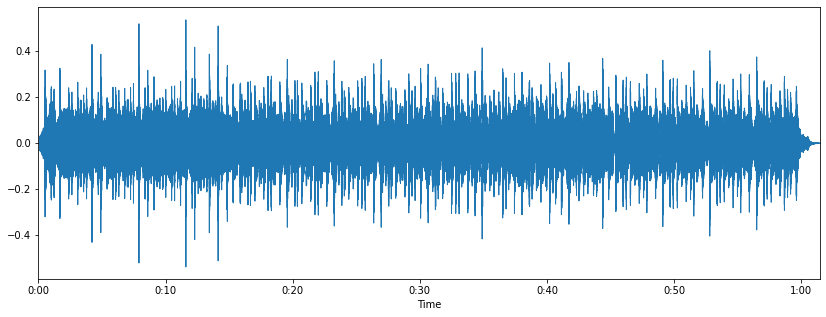

In [32]:
effected = roughrider(y, sample_rate=sr)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(effected, sr=sr)

In [33]:
play_audio(effected[:20 * sr], sample_rate=sr)

Neat! Hear how this plugin affected the sound - it's a compressor, so it's aggressively evened out the volume of the track. (It almost sounds like someone is turning the volume knob in response to how loud the track is, which isn't a bad way to think about how a compressor works!)

Just like before, we can also put this plugin in a chain with other plugins. In fact, let's use the same `board` we used earlier, but just `append(roughrider)` to the end of it:

In [34]:
board.append(roughrider)

for plugin in board:
    print(plugin)

<pedalboard.Phaser rate_hz=1 depth=1 centre_frequency_hz=1300 feedback=0.25 mix=1 at 0x7fe482a0e800>
<pedalboard.LadderFilter mode=pedalboard.LadderFilter.HPF12pedalboard.LadderFilter.BPF12pedalboard.LadderFilter.LPF24pedalboard.LadderFilter.HPF24pedalboard.LadderFilter.BPF24unknown cutoff_hz=329.63 resonance=0.75 drive=1 at 0x7fe4824c0530>
<pedalboard.Gain gain_db=-5 at 0x7fe4824d29a0>
<pedalboard.Reverb room_size=0.75 damping=0.5 wet_level=0.5 dry_level=0.4 width=1 freeze_mode=0 at 0x7fe4824e2ec0>
<pedalboard.Limiter threshold_db=-10 release_ms=100 at 0x7fe4824df3c0>
<pedalboard.VST3Plugin "RoughRider3" (1 channel) at 0x7fe4824e8470>


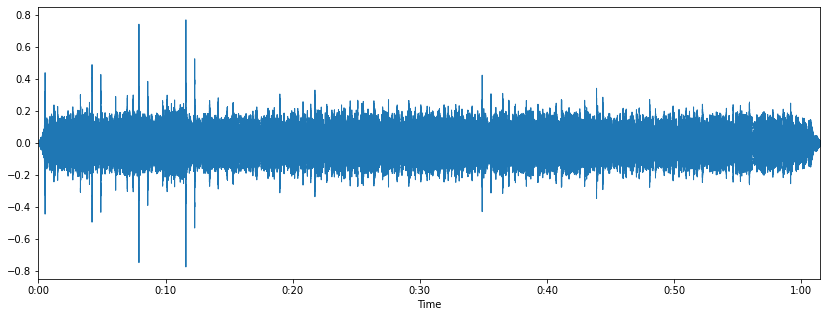

In [35]:
effected = board.process(y)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(effected, sr=sr)

In [36]:
play_audio(effected[:20 * sr], sample_rate=sr)

Again, this sounds pretty different from what we started with!

## Next Steps

We've just scratched the surface of what `pedalboard` can do. Its interface allows you to bridge the worlds of Python and audio production software, but there's plenty of other stuff to try:
- `pedalboard` is multi-thread safe and performant out-of-the-box, which means you can process huge amounts of audio very quickly, with very little memory usage. (No need to use `multiprocessing`!)
- `pedalboard` is compatible with TensorFlow, so with only a couple lines of code, you can use `pedalboard` in your machine learning projects to pre-process or augment data.
- On macOS, `pedalboard` supports Audio Units - meaning you can<sup>1</sup> load commercial audio effects and use them to process audio in your Python scripts.

If you run into any issues, please feel free to [report them on the `pedalboard` GitHub repository](https://github.com/spotify/pedalboard/issues/new). And thanks for trying out `pedalboard`!

---

<sup>1</sup>_in theory_ - this has only been tested with very few plugins so far, and many commercial plugins may require DRM or copy protection (like [iLok](https://www.paceap.com/pace-ilok-cloud.html)) which will likely not work with `pedalboard` without additional changes.